In [116]:
import cv2
import os
import numpy as np
import random
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import matplotlib.pyplot as plt

# Frames Extraction from Videos

In [ ]:
# Function to extract frames from a video
def extract_frames_from_video(video_path, output_folder, frame_interval=30):
    """
    Extract frames from a single video and save them in a subfolder named after the video.
    
    Args:
    - video_path (str): Path to the input video file.
    - output_folder (str): Path to save extracted frames.
    - frame_interval (int): Interval for frame extraction (e.g., save every 30th frame).
    """
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get the total frame count and frame rate
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    
    print(f"Processing {video_path} - Total frames: {total_frames}, FPS: {fps}")

    # Create a subfolder for the video frames
    video_name = os.path.basename(video_path).split('.')[0]  # Get the video name without extension
    video_output_folder = os.path.join(output_folder, video_name)
    if not os.path.exists(video_output_folder):
        os.makedirs(video_output_folder)

    # Extract frames
    count = 0
    saved_frames = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break

        # Save the frame every `frame_interval` frames
        if count % frame_interval == 0:
            frame_name = os.path.join(video_output_folder, f"frame_{saved_frames:04d}.jpg")
            cv2.imwrite(frame_name, frame)
            saved_frames += 1

        count += 1

    # Release the video capture object
    video.release()

    print(f"Frames saved for {video_path}: {saved_frames}")


# Function to process all videos in a directory
def extract_frames_from_directory(input_folder, output_folder, frame_interval=30):
    """
    Extract frames from all videos in a directory and save them to separate subfolders in the output folder.

    Args:
    - input_folder (str): Path to the folder containing video files.
    - output_folder (str): Path to save extracted frames.
    - frame_interval (int): Interval for frame extraction (e.g., save every 30th frame).
    """
    # List all video files in the input directory
    video_files = [f for f in os.listdir(input_folder) if f.endswith(('.mp4', '.avi', '.mov'))]

    # Process each video file
    for video_file in video_files:
        video_path = os.path.join(input_folder, video_file)
        extract_frames_from_video(video_path, output_folder, frame_interval)


# Example usage
input_folder = r"C:\Users\abder\Documents\RDF\Project\data\archive\Human Activity Recognition - Video Dataset\Clapping"  # Folder containing your videos
output_folder = r"C:\Users\abder\Documents\RDF\Project\Sequences\Real"  # Folder to store extracted frames
frame_interval = 15  # Extract one frame every 15 frames (adjust as needed)

extract_frames_from_directory(input_folder, output_folder, frame_interval)


# Faces Extraction

### MTCNN + Resizing

In [5]:
main_folder = r"C:\Users\abder\Documents\RDF\Project\Sequences\Real"
output_folder = r"C:\Users\abder\Documents\RDF\Project\faces\Real"

detector = MTCNN()

os.makedirs(output_folder, exist_ok=True)

for sequence_name in os.listdir(main_folder):
    sequence_path = os.path.join(main_folder, sequence_name)
    
    if os.path.isdir(sequence_path):  # Check if it's a folder
        sequence_output_path = os.path.join(output_folder, sequence_name)
        os.makedirs(sequence_output_path, exist_ok=True)

        for frame_name in os.listdir(sequence_path):
            frame_path = os.path.join(sequence_path, frame_name)
            if frame_name.lower().endswith(('.jpg', '.png', '.jpeg')):  # Image files
                image = cv2.imread(frame_path)
                if image is None:
                    print(f"Could not read image: {frame_path}")
                    continue

                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Detect faces
                results = detector.detect_faces(image_rgb)

                for i, result in enumerate(results):
                    x, y, width, height = result['box']
                    
                    # Ensure coordinates are valid
                    x, y = max(0, x), max(0, y)
                    x_end, y_end = min(x + width, image.shape[1]), min(y + height, image.shape[0])
                    
                    if x_end > x and y_end > y:  # Valid face dimensions
                        face = image[y:y_end, x:x_end]
                        
                        # Resize and save the face
                        face_resized = cv2.resize(face, (224, 224))
                        face_path = os.path.join(sequence_output_path, f"{os.path.splitext(frame_name)[0]}_face_{i}.jpg")
                        cv2.imwrite(face_path, face_resized)
                    else:
                        print(f"Invalid face dimensions for {frame_name}: {result['box']}")

print("Processing complete. Faces saved to:", output_folder)


Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.623.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.624.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.625.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.626.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.627.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.628.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.629.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.630.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.631.jpg
Could not read image: C:\Users\abder\Documents\RDF\Project\Sequences\Real\albert_brooks0\0.632.jpg
Could not 

# Data cleaning

In [5]:
main_folder = r"C:\Users\abder\Documents\RDF\Project\faces\Real"

# Walk through all subfolders in the main folder
for root, _, files in os.walk(main_folder):
    for filename in files:
        # Check if the file does not end with "_0.jpg"
        if not filename.endswith("_0.jpg"):
            file_path = os.path.join(root, filename)
            os.remove(file_path)  # Delete the file
            print(f"Deleted: {file_path}")  # Log deleted files
        else:
            print(f"Keeping: {filename}")  # Log kept files

print("Cleaning complete. Unwanted files have been deleted.")

Keeping: frame_0000_face_0.jpg
Deleted: C:\Users\abder\Documents\RDF\Project\faces\Real\01__exit_phone_room\frame_0000_face_1.jpg
Keeping: frame_0001_face_0.jpg
Deleted: C:\Users\abder\Documents\RDF\Project\faces\Real\01__exit_phone_room\frame_0001_face_1.jpg
Deleted: C:\Users\abder\Documents\RDF\Project\faces\Real\01__exit_phone_room\frame_0001_face_2.jpg
Keeping: frame_0002_face_0.jpg
Keeping: frame_0003_face_0.jpg
Keeping: frame_0004_face_0.jpg
Keeping: frame_0005_face_0.jpg
Keeping: frame_0006_face_0.jpg
Keeping: frame_0007_face_0.jpg
Keeping: frame_0008_face_0.jpg
Keeping: frame_0009_face_0.jpg
Keeping: frame_0010_face_0.jpg
Keeping: frame_0011_face_0.jpg
Keeping: frame_0012_face_0.jpg
Keeping: frame_0013_face_0.jpg
Keeping: frame_0014_face_0.jpg
Keeping: frame_0015_face_0.jpg
Keeping: frame_0016_face_0.jpg
Keeping: frame_0017_face_0.jpg
Keeping: frame_0018_face_0.jpg
Keeping: frame_0019_face_0.jpg
Keeping: frame_0020_face_0.jpg
Keeping: frame_0000_face_0.jpg
Keeping: frame_0001_f

# Data Selection

In [14]:
def select_random_videos(input_folder, output_folder, fraction=0.5):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # List all subfolders in the input folder
    subfolders = os.listdir(input_folder)

    # Group subfolders by their prefix
    groups = {}
    for subfolder in subfolders:
        # Extract prefix based on your folder naming convention
        prefix = subfolder.split('_')[0]  # Adjust as per actual naming convention
        if prefix not in groups:
            groups[prefix] = []
        groups[prefix].append(subfolder)

    # Process each group
    for prefix, video_folders in groups.items():
        # Calculate how many folders to select
        num_to_select = max(1, int(len(video_folders) * fraction))  # Ensure at least one folder is selected

        # Randomly select subfolders
        selected_folders = random.sample(video_folders, num_to_select)

        # Copy the selected folders to the output folder
        for folder in selected_folders:
            # Path for the current subfolder in input
            subfolder_path = os.path.join(input_folder, folder)

            # Create the corresponding output subfolder path
            output_subfolder_path = os.path.join(output_folder, folder)
            os.makedirs(output_subfolder_path, exist_ok=True)

            # Copy all files from the subfolder to the output folder
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                if os.path.isfile(file_path):
                    shutil.copy(file_path, output_subfolder_path)

            print(f"Copied {folder} to {output_folder}")
    print("Processing complete.")

# Define your input and output folders
input_folder = r"C:\Users\abder\Documents\RDF\Project\faces\Fake"
output_folder = r"C:\Users\abder\Documents\RDF\Project\train_faces\Fake"

# Call the function to select random videos
select_random_videos(input_folder, output_folder)

Copied 01_20__walk_down_hall_angry__FW94AIMJ to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_20__kitchen_still__FW94AIMJ to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_20__kitchen_still__D8GWGO2A to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_03__hugging_happy__ISF9SP4G to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_04__hugging_happy__GBC7ZGDP to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_03__talking_against_wall__JZUXXFRB to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_15__exit_phone_room__02HILKYO to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_20__outside_talking_still_laughing__FW94AIMJ to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_09__talking_angry_couch__O8HNNX43 to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_15__hugging_happy__02HILKYO to C:\Users\abder\Documents\RDF\Project\train_faces\Fake
Copied 01_1

# Features Extraction

In [24]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=model.input, outputs=model.output)

In [26]:
def extract_features_from_faces(folder_path):
    video_features = {}  # Dictionary to store features for each video (sequence)
    
    # Loop through each sequence (video) folder
    for sequence_name in os.listdir(folder_path):
        sequence_path = os.path.join(folder_path, sequence_name)
        
        if os.path.isdir(sequence_path):  # Check if it's a folder (video sequence)
            sequence_face_features = []  # List to store features of faces in the current sequence

            # Loop through each image in the sequence folder
            for frame_name in os.listdir(sequence_path):
                frame_path = os.path.join(sequence_path, frame_name)
                if frame_name.lower().endswith(('.jpg', '.png', '.jpeg')):  # Process image files only
                    image = cv2.imread(frame_path)
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # No resizing here as you've already resized the faces
                    face_resized = image_rgb.astype(np.float32) / 255.0  # Assuming the faces are already resized to 224x224

                    # Preprocess the face for ResNet (mean and std normalization)
                    face_resized = preprocess_input(face_resized)

                    # Extract features using ResNet-50 directly
                    face_features = model.predict(np.expand_dims(face_resized, axis=0))

                    # Flatten the feature vector
                    face_features = face_features.flatten()

                    # Append the feature vector to the list for this sequence
                    sequence_face_features.append(face_features)
            
            # Store the features for the current sequence if faces were found
            if sequence_face_features:
                video_features[sequence_name] = np.array(sequence_face_features)
    
    return video_features


folder_path = r"C:\Users\abder\Documents\RDF\Project\Sequences\Real"
video_features = extract_features_from_faces(folder_path)

for sequence_name, features in video_features.items():
    print(f"Sequence: {sequence_name}, Number of frames: {features.shape[0]}")

In [28]:
def extract_features_for_sequence(sequence_path, model):
    """
    Extract features for all frames in a video sequence folder.
    """
    features = []
    for frame_name in sorted(os.listdir(sequence_path)):  # Ensure frames are ordered
        frame_path = os.path.join(sequence_path, frame_name)
        if frame_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            # Preprocess the image for ResNet
            image_batch = preprocess_image(frame_path)
            
            # Extract feature vector using ResNet50
            feature_vector = model.predict(image_batch, verbose=0)
            
            # Flatten the feature vector to 1D
            features.append(feature_vector.flatten())

    return np.array(features)  

In [30]:
def label_and_extract_features(base_folder, model):
    """
    Extract features and labels for all video sequences in the dataset.
    """
    data = []
    labels = []
    
    for label_name, label_value in {'Real': 1, 'Fake': 0}.items():
        folder_path = os.path.join(base_folder, label_name)
        if os.path.isdir(folder_path):
            for sequence_name in os.listdir(folder_path):
                sequence_path = os.path.join(folder_path, sequence_name)
                if os.path.isdir(sequence_path):  # Ensure it's a folder
                    # Extract features for this video sequence
                    features = extract_features_for_sequence(sequence_path, model)
                    data.append(features)  # Store the feature vectors
                    labels.append(label_value)  # Store the label for this sequence

    return data, labels

# Training

In [32]:
faces_train_folder = r"C:\Users\abder\Documents\RDF\Project\train_faces"
data, labels = label_and_extract_features(faces_train_folder, feature_extractor)

print(f"Extracted features for {len(data)} sequences.")
print(f"Example sequence shape: {data[0].shape}")
print(f"Labels: {labels[:5]}")

Extracted features for 1987 sequences.
Example sequence shape: (21, 2048)
Labels: [1, 1, 1, 1, 1]


In [58]:
labels = [1 - label for label in labels]

In [62]:
max_sequence_length = max([seq.shape[0] for seq in data])
X = pad_sequences(data, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

In [78]:
X = np.array(X)
Y = np.array(labels)

In [80]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [94]:
feature_size = X.shape[2]

model = Sequential([
    Input(shape=(max_sequence_length, feature_size)),  
    Masking(mask_value=0.0),  # Masking layer for padded timesteps
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [108]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=32,  
    verbose=1
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9328 - loss: 0.1752 - val_accuracy: 0.9228 - val_loss: 0.1743
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9557 - loss: 0.1296 - val_accuracy: 0.9497 - val_loss: 0.1340
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9546 - loss: 0.1225 - val_accuracy: 0.9396 - val_loss: 0.1737
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9549 - loss: 0.1159 - val_accuracy: 0.9497 - val_loss: 0.1099
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9682 - loss: 0.1054 - val_accuracy: 0.9060 - val_loss: 0.1978
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9579 - loss: 0.1239 - val_accuracy: 0.9631 - val_loss: 0.1032
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9646 - loss: 0.0823 - val_accuracy: 0.9564 - val_loss: 0.1075
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9746 - loss: 0.0676 - val_accuracy: 0.

In [110]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9645 - loss: 0.1645
Test Loss: 0.13460572063922882, Test Accuracy: 0.9698996543884277


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


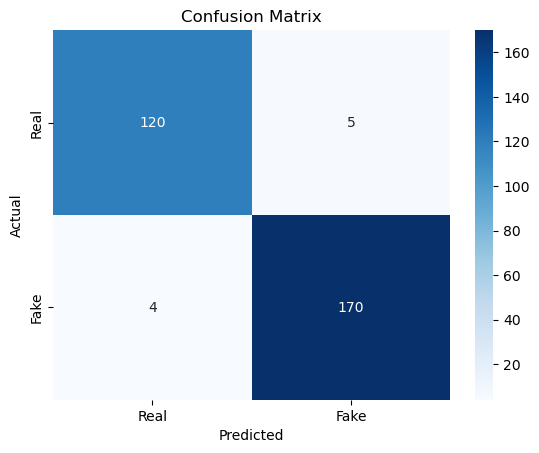

In [118]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()